# Lattice 2D

In [1]:
%matplotlib inline
#
from LRGSG_package.LRGSG import *
from LRGSG_package.LRGSG_plots import imshow_colorbar_caxdivider
from LRGSG_package.LRGSG_utils import move_to_rootf, width_interval
from LRGSG_package.nx_patches import signed_spectral_layout, signedlaplacian_spectrum
#
move_to_rootf(print_tf=True)

cwd: /home/opisthofulax/PhD/projects/complex-networks/LRG-Signed


In [2]:
side = 100
eigenmode = 0
#
theLattice = Lattice2D(#
    side1 = side,
    geometry = 'squared',

)
SLRG_obj = SignedLaplacianAnalysis(#
    system = theLattice,
    initCond = 'all_1', # f'ground_state_{eigenmode}'
    # pflip = 1,
    t_steps = 10,
    no_obs = 200
)
SLRG_obj.init_weights()
#
# neg_weightsG = {((i, j), (i, j+1)): -1 for i in range(SLRG_obj.system.side1) 
#                 for j in [SLRG_obj.system.side2//3, SLRG_obj.system.side2//2]}
neg_weightsH = {(SLRG_obj.system.N//2+SLRG_obj.system.side1//2, 
                 (SLRG_obj.system.N)//2+SLRG_obj.system.side1//2+1): -1,}
                #  (SLRG_obj.system.N//2+SLRG_obj.system.side1//3, 
                #  (SLRG_obj.system.N)//2+SLRG_obj.system.side1//3+1): -1, 
                #  (SLRG_obj.system.N//2+2*SLRG_obj.system.side1//3, 
                #  (SLRG_obj.system.N)//2+2*SLRG_obj.system.side1//3+1): -1}
SLRG_obj.flip_sel_edges(neg_weightsH, 'H')
#
# edges_to_flip = [(0, 1), (0, 2), (0, 3), (2, 5), (1, 12)]
# neg_weights = {e: -1 for e in edges_to_flip}
# SLRG_obj.flip_sel_edges(neg_weights)
#
SLRG_obj.flip_random_fract_edges()

In [3]:
SLRG_obj.laplacian_dynamics_init(
    # window_size=1, 
    # window_shift_y=0,
    # window_shift_x=0,
    # win_val=-1
)

In [4]:
# fixed periodic sopra spin glass
# without rescaling


In [5]:
initial_state = SLRG_obj.status_array.reshape(SLRG_obj.system.syshape)
eigen_state = SLRG_obj.eigV.T[eigenmode].reshape(SLRG_obj.system.syshape)

In [6]:
SLRG_obj.run_laplacian_dynamics(
    rescaled='field',
    saveFrames=True)

Beginning Laplacian dynamics.


 31%|███▏      | 31304/99999 [00:02<00:06, 11343.16it/s]

Convergence reached.


In [7]:
final_state = SLRG_obj.status_array.reshape(SLRG_obj.system.syshape)

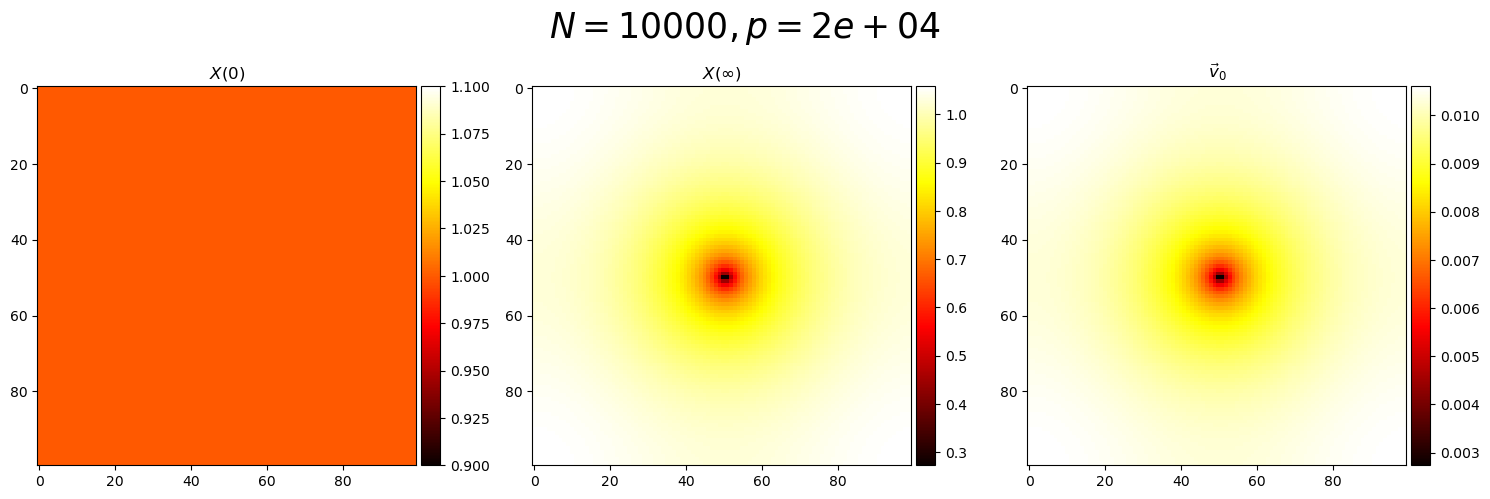

In [8]:
if np.mean(initial_state)*np.mean(eigen_state) < 0:
    eigen_state = -eigen_state
#
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
#
im1 = axs[0].imshow(initial_state, cmap='hot')
_ = imshow_colorbar_caxdivider(im1, axs[0])
axs[0].set_title(r'$X(0)$')
#
im2 = axs[1].imshow(final_state, cmap='hot')
_ = imshow_colorbar_caxdivider(im2, axs[1])
axs[1].set_title(r'$X(\infty)$')
#
im3 = axs[2].imshow(eigen_state, cmap='hot')
_ = imshow_colorbar_caxdivider(im3, axs[2])
axs[2].set_title(r'$\vec{v}_0$')
#
cpflip = SLRG_obj.system.Ne/SLRG_obj.system.Ne_n
fig.suptitle(fr'$N={SLRG_obj.system.N}, p={cpflip:.3g}$', fontsize=25)
fig.tight_layout()

In [9]:
phi_plot = np.log(np.max(eigen_state)-eigen_state)
phi_plot_nnans = phi_plot[(phi_plot != np.inf) & (phi_plot != -np.inf)]
phi_plot = np.nan_to_num(phi_plot, posinf=np.max(phi_plot_nnans), neginf=np.min(phi_plot_nnans))

/tmp/ipykernel_9981/2187982115.py:1: RuntimeWarning: divide by zero encountered in log
  phi_plot = np.log(np.max(eigen_state)-eigen_state)


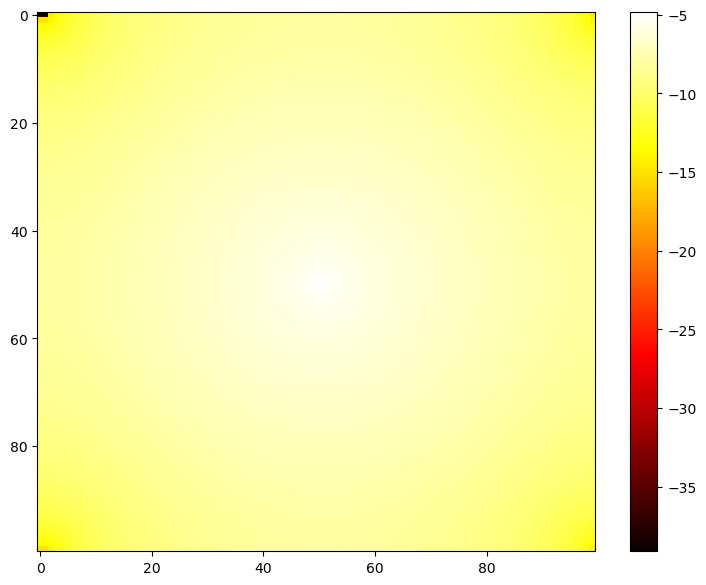

In [10]:
fig, ax1 = plt.subplots(figsize=(9, 7))
im1 = ax1.imshow(phi_plot, cmap=plt.cm.hot, aspect="auto")
plt.colorbar(im1)

In [11]:
phi_plot
halfsize = SLRG_obj.system.side1//2
hcut_halfsize = phi_plot[halfsize, :]
vcut_halfsize = phi_plot[:, halfsize]
critrad = np.sqrt(1.128/(np.pi*0.103))
ball_halfsizeM = halfsize+1-critrad
ball_halfsizeP = halfsize+1+critrad

In [12]:
critrad

1.8670717211181747

In [13]:
from scipy.optimize import curve_fit
from LRGSG_package.LRGSG_utils import line

phi_asym = hcut_halfsize[SLRG_obj.system.side1//2:]
x = np.linspace(0, len(phi_asym), num=len(phi_asym))

idx = 5
params, cov = curve_fit(line, x[:idx], phi_asym[:idx])

Text(0.5, 0, 'x')

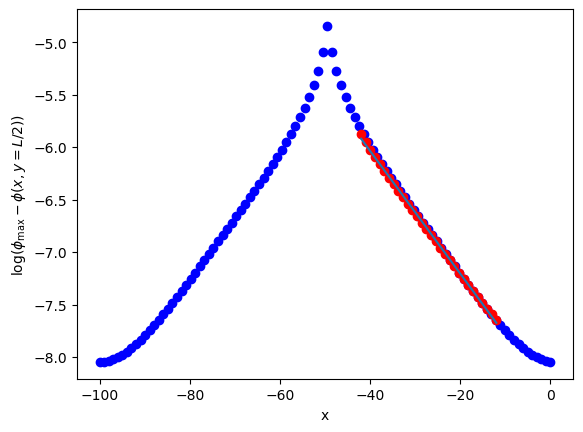

In [18]:
fig, ax = plt.subplots()

cut = phi_plot[:, halfsize]
cutstart = len(cut)//2+8
cutend = cutstart+30

cutcut = cut[cutstart:cutend]
x = np.linspace(cutstart, cutend, num=len(cutcut))-100
x2 = np.linspace(0, len(cut), num=len(cut))-100
ax.plot(x2, cut, 'bo')
ax.plot(x, cutcut, 'ro')
params, cov = curve_fit(line, x, cutcut)
ax.plot(x, line(x, *params))

ax.set_ylabel(r'$\log(\phi_\max-\phi(x, y=L/2))$')
ax.set_xlabel('x')
# plt.xscale('symlog')
# xx = np.linspace(0, SLRG_obj.system.side1//2)
# ax.plot(xx+50, line(xx, *params))
# plt.yscale('log')

In [22]:
-1/params[0]

17.092148291471116